In [1]:
import sys
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

# Add parent directory to path to allow import of config.py
sys.path.append("..")

import config as conf

For our baseline or 'naive' model, we will use a simple linear regression model on enrolment as a function of time. This model is not expected to perform well, but it will give us a baseline for the simplest possible model to compare other models to.

In [2]:
data = pd.read_csv(f'{conf.DATA_PATH}{conf.CLEANED_DATAFILE}')
data

,Census Enrollment,Census Fill Rate,Count of Migrated Data,Current Enrollment,Current Fill Rate,Enrollment Capacity,Ftef,Ftes,Ftes/Ftef,Number Retained,Number Successful,Retention Rate,Sec. Count,Success Rate,Wsch/Ftef,year,semester
0,23035.0,0.659009,873.0,23035.0,0.659009,34954.0,222.960,3388.44,15.197524,19886.000000,16784.0,0.858265,873.0,0.724385,456.131145,2016,FA
1,4940.0,0.455551,212.0,4939.0,0.455459,10844.0,51.831,756.62,14.597828,4619.000000,4143.0,0.906753,212.0,0.813310,439.640370,2016,SU
2,24250.0,0.663693,917.0,24250.0,0.663693,36538.0,221.658,3453.37,15.579722,21096.708858,17768.0,0.854429,917.0,0.719673,467.801749,2017,FA
3,22573.0,0.606361,900.0,22573.0,0.606361,37227.0,220.622,3277.43,14.855409,20203.715960,17130.0,0.857980,900.0,0.727512,445.499542,2017,SP
4,4697.0,0.445171,204.0,4697.0,0.445171,10551.0,48.731,702.63,14.418543,4335.000000,3859.0,0.905578,204.0,0.806142,433.994788,2017,SU
5,25753.0,0.682108,948.0,25753.0,0.682108,37755.0,228.736,3736.85,16.336956,22022.695227,18642.0,0.847614,948.0,0.717552,526.296691,2018,FA
6,22781.0,0.607008,907.0,22790.0,0.607248,37530.0,215.558,3231.18,14.989840,20609.854932,17533.0,0.854932,907.0,0.727329,449.767580,2018,SP
7,4705.0,0.443910,206.0,4705.0,0.443910,10599.0,45.488,609.09,13.390125,4470.000000,3977.0,0.899035,206.0,0.799879,416.373549,2018,SU
8,26206.0,0.685070,965.0,26206.0,0.685070,38253.0,230.480,3796.20,16.470843,22746.407080,18812.0,0.867257,965.0,0.717577,534.423811,2019,FA
9,23752.0,0.622742,925.0,23752.0,0.622742,38141.0,220.660,3366.87,15.258180,20754.737671,17625.0,0.868835,925.0,0.737880,498.663102,2019,SP


To do a simple x, y linear fit, we first need to do a little data formatting. The goal is to make a timeseries where the date is x and enrollment is y.

In [3]:
def decode_semester_strings(semesters):
    '''Takes a list of semester string identifiers and translates
    them into month and day of census. Returns two lists with month
    and day numbers'''
    
    census_months = []
    census_days = []

    for semester in list(semesters):

        if semester == 'FA':
            census_months.append(9)
            census_days.append(8)

        elif semester == 'SP':
            census_months.append(2)
            census_days.append(8)

        elif semester == 'SU':
            census_months.append(5)
            census_days.append(14)

    return census_months, census_days

def make_xy_data(data):
    '''Wapper function takes formatted data and recovers two lists - one of census enrollment
    numbers (returned as y) and the census data (returned as x)'''

    census_months, census_days = decode_semester_strings(data['semester'])

    x = pd.to_datetime(dict(year=data['year'], month=census_months, day=census_days))
    y = data['Census Enrollment']
    
    return x, y

In [4]:
# Get census data and corresponding enrollment number from
# each row in the data

x, y = make_xy_data(data)

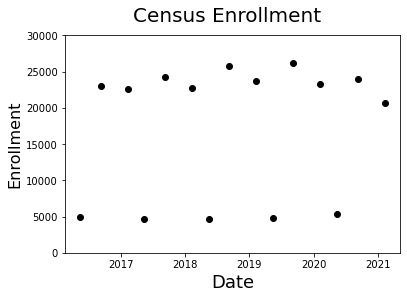

In [5]:
# Plot enrollment numbers over time

fig = plt.figure()
plt.scatter(x, y, color='black')
plt.axis([None, None, 0, 30000])
#plt.xticks(rotation = 45)
fig.suptitle('Census Enrollment', fontsize=20)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Enrollment', fontsize=16)
plt.show()

The orignal plan was to fit this data with one line and call that the minimal model. But looking at the data, I think that is going a bit to far in terms of oversimplifying on purpose to make the other models look good. I think that what we have to do is use two linear fits, one to summer semesters and the other to fall and spring. Even better would be to split into three sets and treat each one individualy, but lets start with just separating summer from fall and spring.

In [6]:
# Split data into summer and fall-spring sets, then remake x, y data for each

SU_data = data[data['semester'] == "SU"]
SU_x, SU_y = make_xy_data(SU_data)

FA_SP_data = data[data['semester'] != "SU" ]
FA_SP_x, FA_SP_y = make_xy_data(FA_SP_data)

census_enrollment_by_date = {
    'SU_dates': SU_x,
    'SU_enrollment': SU_y,
    'FA-SP_dates': FA_SP_x,
    'FA-SP_enrollment': FA_SP_y
}

# Save for later use
with open(f'{conf.DATA_PATH}{conf.CENSUS_ENROLLMENT_BY_DATE}', 'wb') as file:
    pickle.dump(census_enrollment_by_date, file)

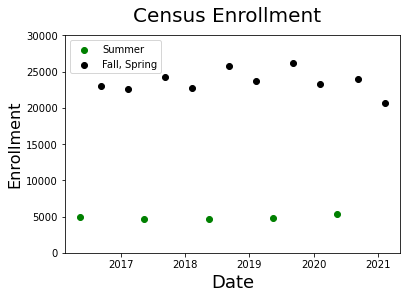

In [7]:
# Replot census enrollment over time as two series

fig = plt.figure()
plt.scatter(SU_x, SU_y, c='green', label='Summer')
plt.scatter(FA_SP_x, FA_SP_y, c='black', label='Fall, Spring')
plt.legend(loc='upper left')
plt.axis([None, None, 0, 30000])
#plt.xticks(rotation = 45)
fig.suptitle('Census Enrollment', fontsize=20)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Enrollment', fontsize=16)
plt.show()

In [8]:
# Fit linear models to the summer and fall-spring data, then make
# predictions from the respective x vectors

# Convert pandas datatime to ms timestamp
SU_x_timestamp = SU_x.values.astype(np.int64) // 10 ** 9
FA_SP_x_timestamp = FA_SP_x.values.astype(np.int64) // 10 ** 9

# Reshape and convert to numpy array
SU_x_timestamp = np.array(SU_x_timestamp).reshape(-1, 1)
FA_SP_x_timestamp = np.array(FA_SP_x_timestamp).reshape(-1, 1)

# Fit linear models
SU_linear_model = LinearRegression().fit(SU_x_timestamp, SU_y)
FA_SP_linear_model = LinearRegression().fit(FA_SP_x_timestamp, FA_SP_y)

# Use models to make predictions
SU_predictions = SU_linear_model.predict(SU_x_timestamp)
FA_SP_predictions = FA_SP_linear_model.predict(FA_SP_x_timestamp)

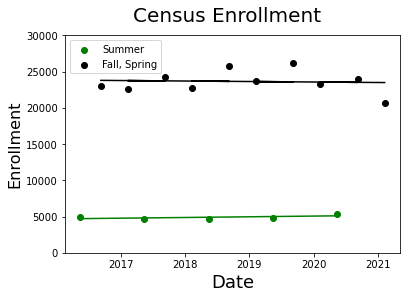

In [9]:
# Replot census enrollment over time as two series
# with linear fits

fig = plt.figure()
plt.scatter(SU_x, SU_y, c='green', label='Summer')
plt.plot(SU_x, SU_predictions, c='green')
plt.scatter(FA_SP_x, FA_SP_y, c='black', label='Fall, Spring')
plt.plot(FA_SP_x, FA_SP_predictions, c='black')
plt.legend(loc='upper left')
plt.axis([None, None, 0, 30000])
#plt.xticks(rotation = 45)
fig.suptitle('Census Enrollment', fontsize=20)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Enrollment', fontsize=16)
plt.show()

In [10]:
# Score summer model
SU_scikit_R_sqr = SU_linear_model.score(SU_x_timestamp, SU_y)
SU_MAE = mean_absolute_error(SU_y, SU_predictions)
print('SciKit-learn R\u00b2: {}'.format(np.round(SU_scikit_R_sqr, 3)))
print(f'Mean absolute error: {int(SU_MAE)}')

SciKit-learn R²: 0.33
Mean absolute error: 189


In [11]:
# Score winter/fall model
FA_SP_scikit_R_sqr = FA_SP_linear_model.score(FA_SP_x_timestamp, FA_SP_y)
FA_SP_MAE = mean_absolute_error(FA_SP_y, FA_SP_predictions)
print('SciKit-learn R\u00b2: {}'.format(np.round(FA_SP_scikit_R_sqr, 3)))
print(f'Mean absolute error: {int(FA_SP_MAE)}')

SciKit-learn R²: 0.004
Mean absolute error: 1171


In [12]:
# Get aggragate MAE for both models
n_SU_points = len(SU_predictions)
n_FA_SP_points = len(FA_SP_predictions)
n = n_SU_points + n_FA_SP_points

MAE = int((SU_MAE*(n_SU_points/n)) + (FA_SP_MAE*(n_FA_SP_points/n)))
print(f'Aggregate MAE: {MAE}')

Aggregate MAE: 843


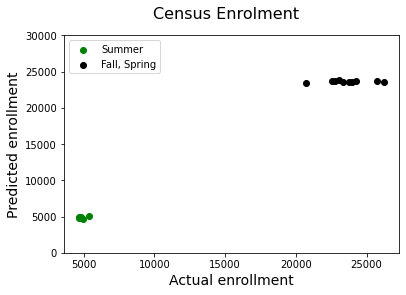

In [13]:
fig = plt.figure()
plt.scatter(SU_y, SU_predictions, c='green', label='Summer')
plt.scatter(FA_SP_y, FA_SP_predictions, c='black', label='Fall, Spring')
plt.legend(loc='upper left')
plt.axis([None, None, 0, 30000])
fig.suptitle('Census Enrolment', fontsize=16)
plt.xlabel('Actual enrollment', fontsize=14)
plt.ylabel('Predicted enrollment', fontsize=14)
plt.show()

Looks OK-ish. Seeme like especialy for fall and spring semesters we are not catching the true variability in enrollment numbers. Also, a major caveat here is we have used all of the data in the fit. Therefore we don't know how well these models will generalize. Let't try again with a train/test split.

In [14]:
# Train test split fall-spring data

# Combine data back into one dataframe
FA_SP_data = pd.DataFrame(list(zip(FA_SP_x, FA_SP_y)),columns =['date', 'enrollment'])

# Split data randomly into training and testing sets
FA_SP_training_data = FA_SP_data.sample(frac=conf.TRAIN_TEST_SPLIT)
FA_SP_test_data = FA_SP_data.drop(FA_SP_training_data.index)

# Seperate dependent and independent variable
FA_SP_training_x = FA_SP_training_data.copy()
FA_SP_test_x = FA_SP_test_data.copy()

FA_SP_training_y = FA_SP_training_x.pop('enrollment')
FA_SP_test_y = FA_SP_test_x.pop('enrollment')

In [15]:
# Train test split summer data

# Combine data back into one dataframe
SU_data = pd.DataFrame(list(zip(SU_x, SU_y)),columns =['date', 'enrollment'])

# Split data randomly into training and testing sets
SU_training_data = SU_data.sample(frac=conf.TRAIN_TEST_SPLIT)
SU_test_data = SU_data.drop(SU_training_data.index)

# Separate dependent and independent variable
SU_training_x = SU_training_data.copy()
SU_test_x = SU_test_data.copy()

SU_training_y = SU_training_x.pop('enrollment')
SU_test_y = SU_test_x.pop('enrollment')

In [16]:
# Re-fit linear models to the summer and fall-spring training 
# data separately, then make predictions for both test sets

# Convert pandas datatime to ms timestamp
SU_training_x_timestamp = SU_training_x.values.astype(np.int64) // 10 ** 9
FA_SP_training_x_timestamp = FA_SP_training_x.values.astype(np.int64) // 10 ** 9

SU_test_x_timestamp = SU_test_x.values.astype(np.int64) // 10 ** 9
FA_SP_test_x_timestamp = FA_SP_test_x.values.astype(np.int64) // 10 ** 9

# Reshape and convert to numpy array
SU_training_x_timestamp = np.array(SU_training_x_timestamp).reshape(-1, 1)
FA_SP_training_x_timestamp = np.array(FA_SP_training_x_timestamp).reshape(-1, 1)

# Fit linear models
SU_linear_model = LinearRegression().fit(SU_training_x_timestamp, SU_training_y)
FA_SP_linear_model = LinearRegression().fit(FA_SP_training_x_timestamp, FA_SP_training_y)

# Use models to make predictions
SU_test_predictions = SU_linear_model.predict(SU_test_x_timestamp)
FA_SP_test_predictions = FA_SP_linear_model.predict(FA_SP_test_x_timestamp)

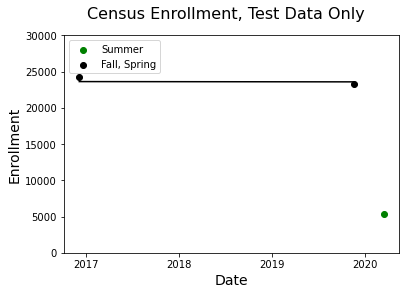

In [17]:
# Replot the models against the test data only to get a feel
# for how we would do against unseen data
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

fig = plt.figure()
plt.scatter(SU_test_x['date'], SU_test_y, c='green', label='Summer')
plt.plot(SU_test_x['date'], SU_test_predictions, c='green')
plt.scatter(FA_SP_test_x['date'], FA_SP_test_y, c='black', label='Fall, Spring')
plt.plot(FA_SP_test_x['date'], FA_SP_test_predictions, c='black')
plt.legend(loc='upper left')
plt.axis([None, None, 0, 30000])
#plt.xticks(rotation = 45)
fig.suptitle('Census Enrollment, Test Data Only', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Enrollment', fontsize=14)

dtFmt = mdates.DateFormatter('%Y') # define the formatting
plt.gca().xaxis.set_major_formatter(dtFmt)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(4))

plt.show()

In [18]:
# Score summer model on test set
#SU_scikit_R_sqr = SU_linear_model.score(SU_test_x_timestamp, SU_test_y)
SU_MAE = mean_absolute_error(SU_test_y, SU_test_predictions)
#print('SciKit-learn R\u00b2: {}'.format(np.round(SU_scikit_R_sqr, 3)))
print(f'Mean absolute error: {int(SU_MAE)}')

Mean absolute error: 618


In [19]:
# Score fall-spring model on test set
#FA_SP_scikit_R_sqr = FA_SP_linear_model.score(FA_SP_test_x_timestamp, FA_SP_test_y)
FA_SP_MAE = mean_absolute_error(FA_SP_test_y, FA_SP_test_predictions)
#print('SciKit-learn R\u00b2: {}'.format(np.round(FA_SP_scikit_R_sqr, 3)))
print(f'Mean absolute error: {int(FA_SP_MAE)}')

Mean absolute error: 443


In [20]:
# Get aggragate MAE for both models
n_SU_points = len(SU_test_predictions)
n_FA_SP_points = len(FA_SP_test_predictions)
n = n_SU_points + n_FA_SP_points

MAE = int((SU_MAE*(n_SU_points/n)) + (FA_SP_MAE*(n_FA_SP_points/n)))
print(f'Aggregate MAE: {MAE}')

Aggregate MAE: 502


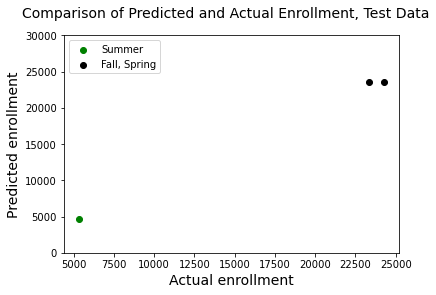

In [21]:
fig = plt.figure()
plt.scatter(SU_test_y, SU_test_predictions, c='green', label='Summer')
plt.scatter(FA_SP_test_y, FA_SP_test_predictions, c='black', label='Fall, Spring')
plt.legend(loc='upper left')
plt.axis([None, None, 0, 30000])
fig.suptitle('Comparison of Predicted and Actual Enrollment, Test Data', fontsize=14)
plt.xlabel('Actual enrollment', fontsize=14)
plt.ylabel('Predicted enrollment', fontsize=14)
plt.show()

OK, not so great on unseen data. Another problem is that depending on the luck of the test train split we can do better or worse on the test data.

Lets see if we can improve, or at least get an idea of how well this generalizes by bootstrapping.

To do that, we need to encapsulate the above operations in functions so that we can easily loop over them.

In [22]:
def train_test_split(x, y, training_data_fraction):
    '''Takes x and y lists of data, combines then randomly 
    samples them. Returns a dict contatining train and test
    x and y datasets'''

    # Combine data into one dataframe
    data = pd.DataFrame(list(zip(x, y)),columns =['date', 'enrollment'])

    # Split data randomly into training and testing sets
    training_data = data.sample(frac=training_data_fraction)
    test_data = data.drop(training_data.index)

    # Seperate dependent and independent variable
    training_x = training_data.copy()
    test_x = test_data.copy()

    training_y = training_x.pop('enrollment')
    test_y = test_x.pop('enrollment')
    
    dataset = {}
    dataset['training_x'] = training_x
    dataset['test_x'] = test_x
    dataset['training_y'] = training_y
    dataset['test_y'] = test_y
    
    return dataset

def train_linear_model(dataset):
    '''Takes dataset, trains simple linear model,
    returns trained model'''
    
    # Extract data from dataset
    training_x = dataset['training_x']
    test_x = dataset['test_x']
    training_y = dataset['training_y']
    test_y = dataset['test_y']
    
    # Convert pandas datatime to ms timestamp
    training_x_timestamp = training_x.values.astype(np.int64) // 10 ** 9
    test_x_timestamp = test_x.values.astype(np.int64) // 10 ** 9

    # Reshape and convert to numpy array
    training_x_timestamp = np.array(training_x_timestamp).reshape(-1, 1)
    test_x_timestamp = np.array(test_x_timestamp).reshape(-1, 1)

    # Fit linear model
    linear_model = LinearRegression().fit(training_x_timestamp, training_y)

    # Use models to make predictions
    test_predictions = linear_model.predict(test_x_timestamp)
    
    return linear_model, test_predictions

In [23]:
results = {}
results['test_scores'] = []
results['SU_models'] = []
results['FA_SP_models'] = []
results['test_labels'] = []
results['test_features'] = []
results['test_predictions'] = []

# Outer training loop
for i in range(conf.N_MODELS):
    print(f'Training model {i}', end='\r')
    
    SU_dataset = train_test_split(SU_x, SU_y, conf.TRAIN_TEST_SPLIT)
    FA_SP_dataset = train_test_split(FA_SP_x, FA_SP_y, conf.TRAIN_TEST_SPLIT)
    
    SU_model, SU_test_predictions = train_linear_model(SU_dataset)
    FA_SP_model, FA_SP_test_predictions = train_linear_model(FA_SP_dataset)
    
    labels = list(SU_dataset['test_y']) + list(FA_SP_dataset['test_y'])
    predicted_labels = list(SU_test_predictions) + list(FA_SP_test_predictions)
    MAE = mean_absolute_error(labels, predicted_labels)
    
    results['test_scores'].append(MAE)
    results['SU_models'].append(SU_model)
    results['FA_SP_models'].append(FA_SP_model)
    results['test_features'].extend(SU_dataset['test_x'])
    results['test_features'].extend(FA_SP_dataset['test_x'])
    results['test_labels'].extend(SU_dataset['test_y'])
    results['test_labels'].extend(FA_SP_dataset['test_y'])
    results['test_predictions'].extend(SU_test_predictions)
    results['test_predictions'].extend(FA_SP_test_predictions)

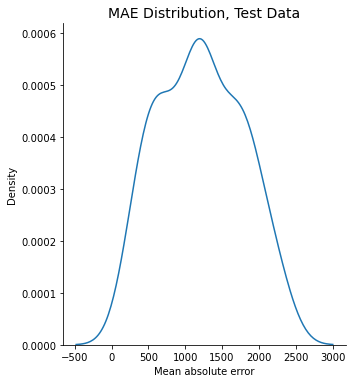

In [24]:
# Plot distribution of MAE scores from each model
sns.displot(results['test_scores'], kind="kde")
plt.xlabel('Mean absolute error')
plt.title('MAE Distribution, Test Data', fontsize=14)

plt.show()

Looks like most models score arround 1000 MAE on the test set. Now, lets use the ensemble to make some predictions.

In [25]:
# Empty list to hold summer predictions
SU_predictions = []

SU_x_timestamp = SU_x.values.astype(np.int64) // 10 ** 9
SU_x_timestamp = np.array(SU_x_timestamp).reshape(-1, 1)

for model in results['SU_models']:
    predicted_enrollment = model.predict(SU_x_timestamp)
    SU_predictions.append(predicted_enrollment)

# Average the predictions from each model
SU_predicted_enrollment = np.mean(np.array(SU_predictions), axis=0)

In [26]:
# Empty list to hold fall-spring predictions
FA_SP_predictions = []

FA_SP_x_timestamp = FA_SP_x.values.astype(np.int64) // 10 ** 9
FA_SP_x_timestamp = np.array(FA_SP_x_timestamp).reshape(-1, 1)

for model in results['FA_SP_models']:
    predicted_enrollment = model.predict(FA_SP_x_timestamp)
    FA_SP_predictions.append(predicted_enrollment)

# Average the predictions from each model
FA_SP_predicted_enrollment = np.mean(np.array(FA_SP_predictions), axis=0)

In [27]:
ensamble_predictions = list(SU_predicted_enrollment) + list(FA_SP_predicted_enrollment)
labels = list(SU_y) + list(FA_SP_y)

results['ensamble_predictions'] = ensamble_predictions
results['labels'] = labels

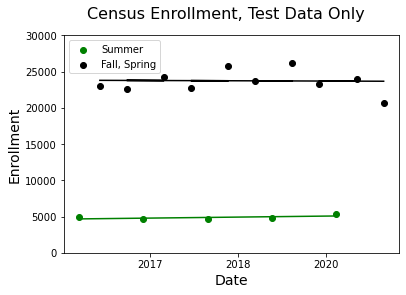

In [28]:
# Replot the models against the test data only to get a feel
# for how we would do against unseen data
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

fig = plt.figure()
plt.scatter(SU_x, SU_y, c='green', label='Summer')
plt.plot(SU_x, SU_predicted_enrollment, c='green')
plt.scatter(FA_SP_x, FA_SP_y, c='black', label='Fall, Spring')
plt.plot(FA_SP_x, FA_SP_predicted_enrollment, c='black')
plt.legend(loc='upper left')
plt.axis([None, None, 0, 30000])
#plt.xticks(rotation = 45)
fig.suptitle('Census Enrollment, Test Data Only', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Enrollment', fontsize=14)

dtFmt = mdates.DateFormatter('%Y') # define the formatting
plt.gca().xaxis.set_major_formatter(dtFmt)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(4))

plt.show()

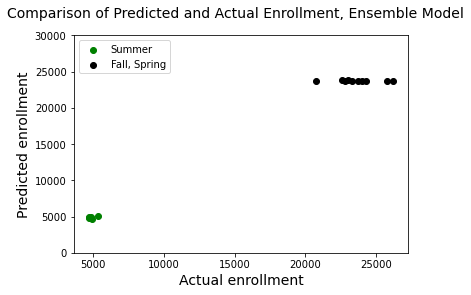

In [29]:
fig = plt.figure()
plt.scatter(SU_y, SU_predicted_enrollment, c='green', label='Summer')
plt.scatter(FA_SP_y, FA_SP_predicted_enrollment, c='black', label='Fall, Spring')
plt.legend(loc='upper left')
plt.axis([None, None, 0, 30000])
fig.suptitle('Comparison of Predicted and Actual Enrollment, Ensemble Model', fontsize=14)
plt.xlabel('Actual enrollment', fontsize=14)
plt.ylabel('Predicted enrollment', fontsize=14)
plt.show()

In [30]:
labels = list(SU_y) + list(FA_SP_y)
predicted_labels = list(SU_predicted_enrollment) + list(FA_SP_predicted_enrollment)
MAE = mean_absolute_error(labels, predicted_labels)

print(f'Ensamble MAE: {int(MAE)}')

Ensamble MAE: 834


Last thing before we move on - lets set up a confidence interval around an example prediction.

In [31]:
# Pick one point to predict
target = list(FA_SP_x_timestamp)[6]

In [32]:
# Empty list to hold fall-spring predictions
FA_SP_predictions = []

for model in results['FA_SP_models']:
    predicted_enrollment = model.predict([target])
    FA_SP_predictions.extend(predicted_enrollment)

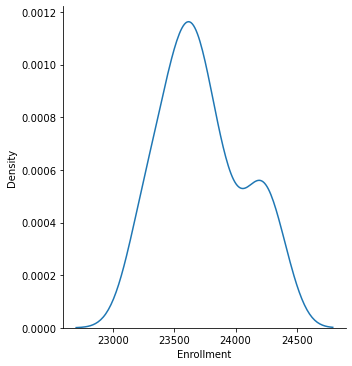

In [33]:
# Plot distribution of predictions from each model
sns.displot(FA_SP_predictions, kind="kde")
plt.xlabel('Enrollment')

plt.show()

In [34]:
import scipy.stats as st

mean = np.mean(FA_SP_predictions)
low, high = st.norm.interval(alpha=0.95, loc=np.mean(FA_SP_predictions), scale=st.sem(FA_SP_predictions))

print(f'Mean: {int(mean)}, 95% CI: {int(low)}-{int(high)}')
print(f'True value: {int(list(FA_SP_y)[6])}')

Mean: 23726, 95% CI: 23660-23793
True value: 23752


In [35]:
# Save results
pkl_filename = f'{conf.RESULTS_PATH}{conf.SIMPLE_LINEAR_MODEL_RESULTS_FILE}'

with open(pkl_filename, 'wb') as file:
    pickle.dump(results, file)